# Realtime Optical Character Recognition (OCR)

Optical Character Recognition (OCR) is the use of technology for converting of printed, scanned paper document, handwritten content, or image-only digital documents into a machine-readable and searchable digital data format. In essence, OCR involves identifying the included text and translating the characters into code that can be used for data processing. 

In this project OpenCV, Python, and Tesseract are used to implement Optical Character Recognition (OCR) for following tasks:

- **Text Detection** 
- **Text Recognition** 
- **Realtime Text Detection** 

Tesseract.v4 is utilized here which includes a highly accurate deep learning-based model for text recognition. The OpenCV OCR pipeline here includes two steps. The text detection is performed in the first step using OpenCV’s EAST text detector, a highly accurate deep learning algorithm trained to detect text in natural scene images. In the second step, the ROI (region of interest) of the detected texts will be passed to Tesseract to extract characters.  



In [20]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from utils import forward_passer, box_extractor
from imutils.object_detection import non_max_suppression

import time
import imutils
from imutils.video import VideoStream
from imutils.video import FPS

Tesseract is a highly popular open source OCR engine, currently supported by Google. It needs to be installed, first. Please follow the link below for the instruction depending on the operating system:

https://github.com/tesseract-ocr/tessdoc#binaries


The location of the installed folder needs to be updated in the following section.

In [21]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\mhoss\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'

**OpenCV’s EAST text detector** is used here to detect the presence of text in an image. The output of EAST text detector is the bounding box (x, y)-coordinates of text ROIs. The extracted ROIs will be passed to Tesseract v4’s LSTM deep learning text recognition algorithm for the actual OCR results. Finally, the bounding boxes and OpenCV OCR results will also be drawn on output images.

The EAST text detector is pre-trained CNN network for text detection and ready to go. The model is already trained and readily provided with OpenCV. 

**Please download the file "frozen_east_text_detection.pb" and copy it in the root folder of the project.**

In [23]:
EAST_path = 'frozen_east_text_detection.pb'


some default values that will be used later in the project

In [24]:
min_confidence = 0.4               # minimum confidence to process a region

width = 320                        # resized image width (multiple of 32) with a default of 320
height = 320                       # resized image height (multiple of 32) with a default of 320    h, w = image.shape[:2]

Following are a couple of helper functions to resize the input images and extract the ounding boxes.

In [25]:
def resize_image(image):
    """
    Re-sizes image to given width & height
    :param image: image to resize
    :param width: new width
    :param height: new height
    :return: modified image, ratio of new & old height and width
    """

    h, w = image.shape[:2]
    
    ratio_w = w / width
    ratio_h = h / height

    image = cv2.resize(image, (width, height))

    return image, ratio_w, ratio_h

In [26]:
def box_extraction(image, min_confidence):
    # layers used for ROI recognition
    layer_names = ['feature_fusion/Conv_7/Sigmoid',
                   'feature_fusion/concat_3']

    # pre-loading the frozen graph
    #print("[INFO] loading the detector...")
    net = cv2.dnn.readNet(EAST_path)

    # getting results from the model
    scores, geometry = forward_passer(net, image, layers=layer_names)

    # decoding results from the model
    rectangles, confidences = box_extractor(scores, geometry, min_confidence)

    # applying non-max suppression to get boxes depicting text regions
    boxes = non_max_suppression(np.array(rectangles), probs=confidences)
    
    return boxes    

**Following is the function to detect text in the input image and draw bounding boxes around the detected texts:**

In [27]:
def text_detection(image, min_confidence):
    # reading in image
    image = cv2.imread(image)
    orig_image = image.copy()

    # resizing image
    image, ratio_w, ratio_h = resize_image(image)

    boxes = box_extraction(image, min_confidence)

    # drawing rectangles on the image
    for (start_x, start_y, end_x, end_y) in boxes:
        start_x = int(start_x * ratio_w)
        start_y = int(start_y * ratio_h)
        end_x = int(end_x * ratio_w)
        end_y = int(end_y * ratio_h)

        cv2.rectangle(orig_image, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)

    #cv2.imshow("Detection", orig_image)
    #cv2.waitKey(0)
    plt.figure(figsize=(12,12))
    plt.imshow(orig_image)

[INFO] detection in 0.56 seconds


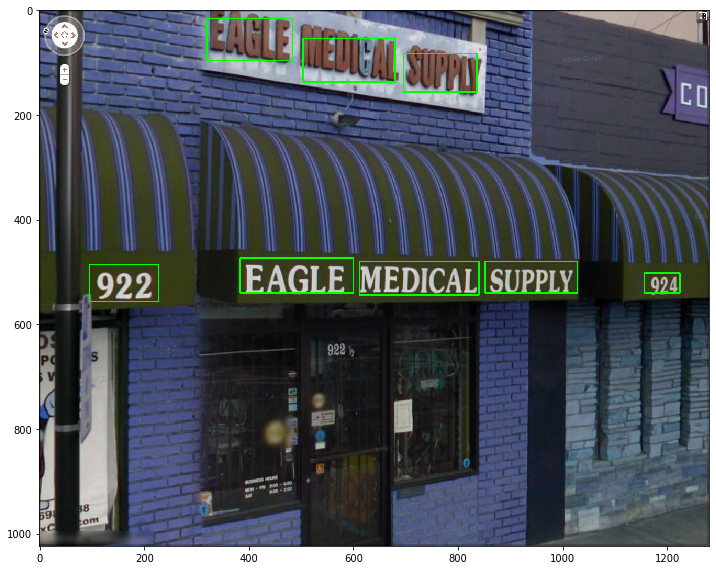

In [28]:
image_path = 'images\input_text_detection.jpg'
text_detection(image=image_path, min_confidence=0.4)

**Following is the function for text recognition and extract words from the detected text in the input image and draw bounding boxes around the detected texts:**

In [29]:
def text_recognition(image, min_confidence, padding):

    # reading in image
    image = cv2.imread(image)
    orig_image = image.copy()
    orig_h, orig_w = orig_image.shape[:2]

    # resizing image
    image, ratio_w, ratio_h = resize_image(image)

    boxes = box_extraction(image, min_confidence)

    results = []

    # text recognition main loop
    for (start_x, start_y, end_x, end_y) in boxes:
        start_x = int(start_x * ratio_w)
        start_y = int(start_y * ratio_h)
        end_x = int(end_x * ratio_w)
        end_y = int(end_y * ratio_h)

        dx = int((end_x - start_x) * padding)
        dy = int((end_y - start_y) * padding)

        start_x = max(0, start_x - dx)
        start_y = max(0, start_y - dy)
        end_x = min(orig_w, end_x + (dx*2))
        end_y = min(orig_h, end_y + (dy*2))

        # ROI to be recognized
        roi = orig_image[start_y:end_y, start_x:end_x]

        # recognizing text
        config = '-l eng --oem 1 --psm 7'
        text = pytesseract.image_to_string(roi, config=config)

        # collating results
        results.append(((start_x, start_y, end_x, end_y), text))

    # sorting results top to bottom
    results.sort(key=lambda r: r[0][1])

    # printing OCR results & drawing them on the image
    output = orig_image.copy()
    for (start_x, start_y, end_x, end_y), text in results:

        print('OCR Result')
        print('**********')
        print(f'{text}\n')

        # stripping out ASCII characters
        text = ''.join([c if ord(c) < 128 else "" for c in text]).strip()
        #output = orig_image.copy()
        cv2.rectangle(output, (start_x, start_y), (end_x, end_y), (0, 0, 255), 2)
        cv2.putText(output, text, (start_x, start_y - 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)

    #cv2.imshow('Detection', output)
    #cv2.waitKey(0)
    plt.figure(figsize=(12,12))
    plt.imshow(output)
    

[INFO] detection in 0.41 seconds
OCR Result
**********
=


OCR Result
**********
MUSEUM


OCR Result
**********
SPACE


OCR Result
**********
AIR &




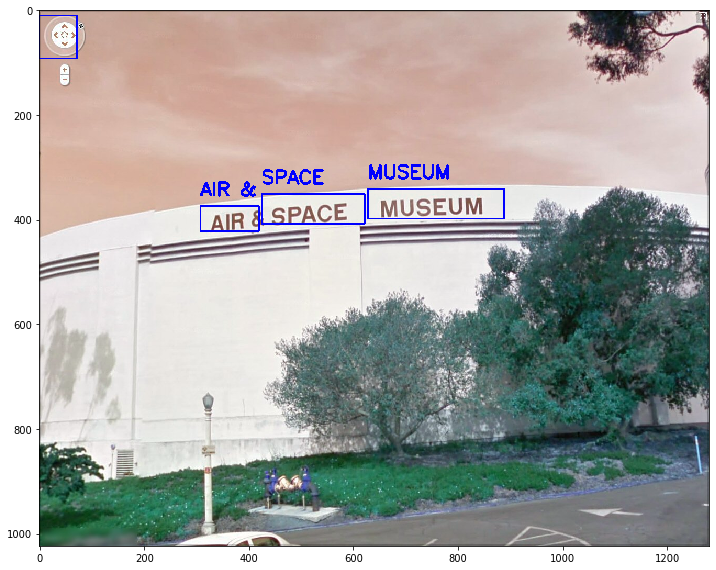

In [31]:
image_path = 'images\input_text_recognition.jpg'
text_recognition(image=image_path, min_confidence=0.5, padding = 0.1)

**Following is the function for realtime text detection from an input video file and draw bounding boxes around the detected texts in each frame of the video and write the processed video as output.mp4**

In [10]:
def realtime_text_detection(video, min_confidence):

    # initialize the width & height variables
    w, h = None, None
    new_w, new_h = width, height
    ratio_w, ratio_h = None, None
    writer = None

    if not video:
        # start webcam feed
        print("[INFO] starting video stream...")
        vs = VideoStream(src=0).start()
        time.sleep(1)

    else:
        # load video
        vs = cv2.VideoCapture(video)

    fps = FPS().start()

    # amin loop
    while True:

        # read frame
        frame = vs.read()
        frame = frame[1] if video else frame

        if frame is None:
            break

        frame = imutils.resize(frame, width=1000)
        orig = frame.copy()

        if w is None or h is None:
            h, w = frame.shape[:2]
            ratio_w = w / float(new_w)
            ratio_h = h / float(new_h)

        # resize frame
        frame = cv2.resize(frame, (new_w, new_h))
        
        boxes = box_extraction(frame, min_confidence)
        

        # drawing rectangles on the frmae
        for (start_x, start_y, end_x, end_y) in boxes:
            start_x = int(start_x * ratio_w)
            start_y = int(start_y * ratio_h)
            end_x = int(end_x * ratio_w)
            end_y = int(end_y * ratio_h)

            cv2.rectangle(orig, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)

        fps.update()

        cv2.imshow("Detection", orig)
        key = cv2.waitKey(1) & 0xFF

        if (key == ord('q')) or (key == 27):
            break
            
           
        # check if the video writer is None
        if writer is None:
            # initialize our video writer
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            writer = cv2.VideoWriter("output.mp4", fourcc, 30,(w, h), True)
        # write the output frame to disk
        new_dim = (w,h)
        writer.write(cv2.resize(orig,new_dim, interpolation = cv2.INTER_AREA))
                                    
            
    fps.stop()
    print(f"[INFO] elapsed time {round(fps.elapsed(), 2)}")
    print(f"[INFO] approx. FPS : {round(fps.fps(), 2)}")

    # releasing catch points after operation
    if not video:
        vs.stop()

    else:
        vs.release()
        writer.release()

    cv2.destroyAllWindows()

In [33]:
video_path = 'images\input_video.mp4'
realtime_text_detection(video=video_path, min_confidence=0.8)

[INFO] detection in 0.39 seconds
[INFO] detection in 0.26 seconds
[INFO] detection in 0.25 seconds
[INFO] detection in 0.25 seconds
[INFO] detection in 0.24 seconds
[INFO] detection in 0.27 seconds
[INFO] detection in 0.24 seconds
[INFO] detection in 0.24 seconds
[INFO] detection in 0.25 seconds
[INFO] detection in 0.27 seconds
[INFO] detection in 0.25 seconds
[INFO] detection in 0.28 seconds
[INFO] detection in 0.31 seconds
[INFO] detection in 0.28 seconds
[INFO] detection in 0.27 seconds
[INFO] detection in 0.31 seconds
[INFO] detection in 0.28 seconds
[INFO] detection in 0.31 seconds
[INFO] detection in 0.35 seconds
[INFO] detection in 0.36 seconds
[INFO] detection in 0.35 seconds
[INFO] detection in 0.36 seconds
[INFO] detection in 0.35 seconds
[INFO] detection in 0.36 seconds
[INFO] detection in 0.36 seconds
[INFO] detection in 0.36 seconds
[INFO] detection in 0.35 seconds
[INFO] detection in 0.37 seconds
[INFO] detection in 0.29 seconds
[INFO] detection in 0.39 seconds
[INFO] det

[INFO] detection in 0.39 seconds
[INFO] detection in 0.38 seconds
[INFO] detection in 0.52 seconds
[INFO] detection in 0.48 seconds
[INFO] detection in 0.39 seconds
[INFO] detection in 0.41 seconds
[INFO] detection in 0.37 seconds
[INFO] detection in 0.39 seconds
[INFO] detection in 0.38 seconds
[INFO] detection in 0.45 seconds
[INFO] detection in 0.54 seconds
[INFO] detection in 0.41 seconds
[INFO] detection in 0.39 seconds
[INFO] detection in 0.37 seconds
[INFO] detection in 0.37 seconds
[INFO] detection in 0.51 seconds
[INFO] detection in 0.48 seconds
[INFO] detection in 0.52 seconds
[INFO] detection in 0.42 seconds
[INFO] detection in 0.31 seconds
[INFO] detection in 0.35 seconds
[INFO] detection in 0.44 seconds
[INFO] detection in 0.47 seconds
[INFO] detection in 0.41 seconds
[INFO] detection in 0.4 seconds
[INFO] detection in 0.38 seconds
[INFO] detection in 0.53 seconds
[INFO] detection in 0.39 seconds
[INFO] detection in 0.37 seconds
[INFO] detection in 0.38 seconds
[INFO] dete